# Pruning model for MNIST dataset
find the differences between Unstructured Pruning and Structured Pruning
observe the structure of weights after the two pruning methods

In [ ]:
# # https://github.com/googlecolab/colabtools/issues/2600
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [1]:
!pip install numpy
!pip install tensorflow-model-optimization
!pip install matplotlib

In [2]:
import shutil
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, datasets, utils, callbacks, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import tempfile
import os
%load_ext tensorboard



## Train a model for MNIST without pruning

To perform pruning on the ResNet-20 model, we will first try pruning a simpler custom model that classifies the MNIST dataset.

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.Conv2D(32, 5, padding='same', activation='relu', input_shape=(28,28,1)),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
  keras.layers.Conv2D(64, 5, padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.ReLU(),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
  keras.layers.Flatten(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)
# Print model summary
model.summary()

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/4
1688/1688 [==============================] - 13s 5ms/step - loss: 0.1741 - accuracy: 0.9528 - val_loss: 0.0622 - val_accuracy: 0.9792
Epoch 2/4
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0672 - accuracy: 0.9799 - val_loss: 0.0402 - val_accuracy: 0.9892
Epoch 3/4
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0364 - val_accuracy: 0.9898
Epoch 4/4
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.0293 - val_accuracy: 0.9922
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)         

In [10]:
# Model accuracy before pruning
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.keras')
model.save(keras_file)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9936000108718872
Saved baseline model to: /tmp/tmp5h1kafl3.keras


## Prune whole model

In [19]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}
model_whole_prune = keras.Sequential([
    keras.layers.Conv2D(
            32, 5, padding='same', activation='relu',
            input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Conv2D(
            64, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(
            1024, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10)
])

model_whole_prune = prune_low_magnitude(model_whole_prune, **pruning_params_sparsity_0_5)

model_whole_prune.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_whole_prune.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 32)        1634      
 _6 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 32)        1         
 oling2d_8 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 64)        102466    
 _7 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_batch_  (None, 14, 14, 64)        257       
 normalization_4 (PruneLowM                                      
 agnitude)                                            

In [20]:
# Model accuracy after pruning
batch_size = 128
epochs = 4

model_whole_prune.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=tfmot.sparsity.keras.UpdatePruningStep(),
    validation_split=0.1)

_, pruned_whole_model_accuracy = model_whole_prune.evaluate(test_images, test_labels, verbose=0)
print('Pruned whole model test accuracy:', pruned_whole_model_accuracy)

Epoch 1/4
422/422 [==============================] - 8s 10ms/step - loss: 0.2789 - accuracy: 0.9365 - val_loss: 0.1793 - val_accuracy: 0.9875
Epoch 2/4
422/422 [==============================] - 4s 9ms/step - loss: 0.0600 - accuracy: 0.9815 - val_loss: 0.0412 - val_accuracy: 0.9893
Epoch 3/4
422/422 [==============================] - 5s 13ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0352 - val_accuracy: 0.9893
Epoch 4/4
422/422 [==============================] - 4s 9ms/step - loss: 0.0360 - accuracy: 0.9883 - val_loss: 0.0323 - val_accuracy: 0.9913
Pruned whole model test accuracy: 0.989799976348877


## Prune model layer by layer

In [13]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params_2_by_4 = {
    'sparsity_m_by_n': (2, 4),
}
pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}
model_layer_prune = keras.Sequential([
    prune_low_magnitude(
        keras.layers.Conv2D(
            32, 5, padding='same', activation='relu',
            input_shape=(28, 28, 1),
            name="pruning_sparsity_0_5"),
        **pruning_params_sparsity_0_5),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    prune_low_magnitude(
        keras.layers.Conv2D(
            64, 5, padding='same',
            name="structural_pruning"),
        **pruning_params_2_by_4),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Flatten(),
    prune_low_magnitude(
        keras.layers.Dense(
            1024, activation='relu',
            name="structural_pruning_dense"),
        **pruning_params_2_by_4),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10)
])

model_layer_prune.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_layer_prune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_prunin  (None, 28, 28, 32)        1634      
 g_sparsity_0_5 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 prune_low_magnitude_struct  (None, 14, 14, 64)        102466    
 ural_pruning (PruneLowMagn                                      
 itude)                                                          
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                     

In [14]:
# Model accuracy after pruning
batch_size = 128
epochs = 4

model_layer_prune.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=tfmot.sparsity.keras.UpdatePruningStep(),
    validation_split=0.1)

_, pruned_layer_model_accuracy = model_layer_prune.evaluate(test_images, test_labels, verbose=0)
print('Pruned layer model test accuracy:', pruned_layer_model_accuracy)

Epoch 1/4
422/422 [==============================] - 8s 10ms/step - loss: 0.2194 - accuracy: 0.9392 - val_loss: 0.1568 - val_accuracy: 0.9860
Epoch 2/4
422/422 [==============================] - 3s 8ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0356 - val_accuracy: 0.9892
Epoch 3/4
422/422 [==============================] - 3s 8ms/step - loss: 0.0416 - accuracy: 0.9874 - val_loss: 0.0425 - val_accuracy: 0.9867
Epoch 4/4
422/422 [==============================] - 4s 9ms/step - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.0381 - val_accuracy: 0.9897
Pruned layer model test accuracy: 0.989300012588501


In [15]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned whole model test accuracy:', pruned_whole_model_accuracy)
print('Pruned layer model test accuracy:', pruned_layer_model_accuracy)

Baseline test accuracy: 0.9936000108718872
Pruned whole model test accuracy: 0.9901000261306763
Pruned layer model test accuracy: 0.989300012588501


# Visualize

In [21]:
# Once a model has been pruned to required sparsity, this method can be used to restore the original model with the sparse weights
model = model_layer_prune
model = tfmot.sparsity.keras.strip_pruning(model)

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_file = 'pruned_model_mnist.tflite'
print('Saved converted pruned model to:', tflite_file)
tf.io.write_file(tflite_file, tflite_model)

Saved converted pruned model to: pruned_model_mnist.tflite


In [23]:
# Model Sparsity after pruning
from __future__ import print_function
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_utils


# Dont check layer if its name has one of word from this list.
IGNORE_LIST = [
    "relu", "pooling", "reshape", "identity", "input", "add", "flatten"
]

def ignore_tensor(details, ignore_list):
  """Returns boolean that indicates whether to ignore the tensor."""
  name = details["name"].casefold()
  if not name:
    return True
  for to_ignore in ignore_list:
    if to_ignore in name:
      return True
  return False

def calculate_sparsity(weights):
  number_of_weights = np.size(weights)
  number_of_non_zero_weights = np.count_nonzero(weights)
  sparsity = 1.0 - float(
      number_of_non_zero_weights
  ) / number_of_weights if number_of_non_zero_weights != 0 else 1.0
  return sparsity

def run(input_tflite_path, m_by_n):
  """Checks type of sparsity for each layer of the model."""

  interpreter = tf.lite.Interpreter(model_path=input_tflite_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()
  # Don't consider layers that can't be pruned.
  details = [x for x in details if not ignore_tensor(x, IGNORE_LIST)]

  for detail in details:
    name = detail["name"]
    shape = detail["shape"]
    weights = interpreter.tensor(detail["index"])()

    weights_ts = tf.constant(weights)
    pruned_m_by_n = pruning_utils.is_pruned_m_by_n(weights_ts, m_by_n, "C_IN")
    sparsity = calculate_sparsity(weights_ts)

    print(f"{name}: shape: {shape}, sparsity: {sparsity}, "
          f"{m_by_n[0]}_by_{m_by_n[1]} sparsity: {pruned_m_by_n}.")

if __name__ == "__main__":
  run(tflite_file, (2,4))


arith.constant: shape: [64], sparsity: 0.0, 2_by_4 sparsity: False.
arith.constant1: shape: [64  5  5 32], sparsity: 0.5, 2_by_4 sparsity: True.
arith.constant2: shape: [  10 1024], sparsity: 0.0, 2_by_4 sparsity: False.
arith.constant3: shape: [1024 3136], sparsity: 0.5, 2_by_4 sparsity: True.
arith.constant4: shape: [1024], sparsity: 0.0, 2_by_4 sparsity: False.
arith.constant5: shape: [2], sparsity: 0.0, 2_by_4 sparsity: True.
sequential_2/pruning_sparsity_0_5/Conv2D: shape: [32  5  5  1], sparsity: 0.5, 2_by_4 sparsity: True.
StatefulPartitionedCall:0: shape: [ 1 10], sparsity: 0.09999999999999998, 2_by_4 sparsity: False.


In [53]:
# Load tflite file with the created pruned model
interpreter = tf.lite.Interpreter(model_path=tflite_file)
interpreter.allocate_tensors()

details = interpreter.get_tensor_details()

# Weights of the dense layer that has been pruned.
tensor_name = 'arith.constant3'
detail = [x for x in details if tensor_name in x["name"]]
print(detail)
# We need the first layer.
tensor_data = interpreter.tensor(detail[0]["index"])()

[{'name': 'arith.constant3', 'index': 4, 'shape': array([1024, 3136], dtype=int32), 'shape_signature': array([1024, 3136], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [54]:
print(f"Shape of Dense layer is {tensor_data}")

Shape of Dense layer is [[ 0.01389286 -0.         -0.         ... -0.         -0.0396875
  -0.03498471]
 [-0.         -0.04329443 -0.         ... -0.          0.02436727
  -0.        ]
 [ 0.0364822   0.          0.         ... -0.          0.02490944
  -0.02863855]
 ...
 [ 0.01951227 -0.         -0.04398401 ... -0.03904013  0.
   0.        ]
 [-0.          0.016315   -0.03314561 ... -0.01644339  0.
   0.0384598 ]
 [-0.04277081 -0.         -0.03277914 ...  0.0097111  -0.
  -0.0159816 ]]


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# The value 24 is chosen for convenience.
width = height = 24

subset_values_to_display = tensor_data[0:height, 0:width]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

In [56]:
def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

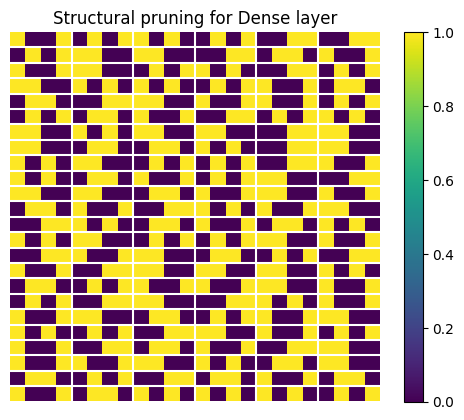

In [57]:
plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structural pruning for Dense layer")
plt.show()

In [60]:
# Get weights of the convolutional layer that has been pruned with 2 by 4 sparsity.
tensor_name = 'arith.constant1'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[0]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (64, 5, 5, 32)


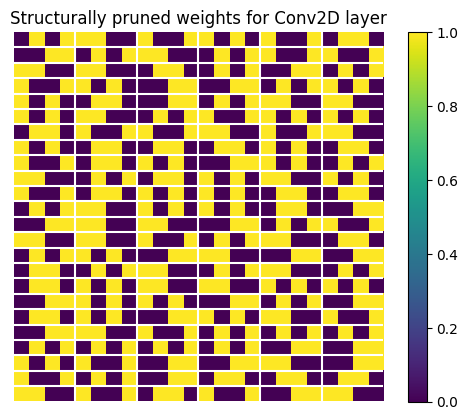

In [61]:
weights_to_display = tf.reshape(tensor_data, [tf.reduce_prod(tensor_data.shape[:-1]), -1])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 1e-9, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structurally pruned weights for Conv2D layer")
plt.show()

In [62]:
# Get weights of the convolutional layer that has been pruned with random pruning.
tensor_name = 'pruning_sparsity_0_5/Conv2D'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[0]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (32, 5, 5, 1)


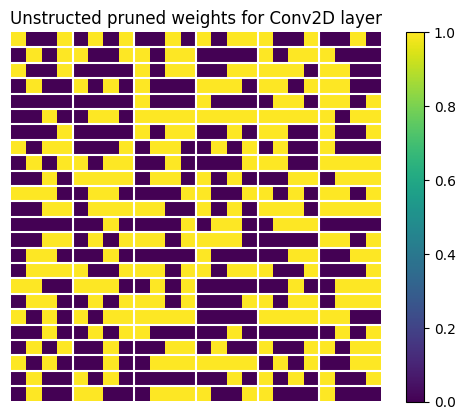

In [63]:
weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Unstructed pruned weights for Conv2D layer")
plt.show()